# Исходные данные
Дан .csv файл с количеством рекламных событий по дням. 11 апреля произошел резкий скачок. <br>
Необходимо воспроизвести график и узнать, **является ли данный всплеск ошибкой в сборе статистик или этот рост чем-то обоснован.**

# Разобьем задачу на подпункты
1. [Воспроизведение графика](#Воспроизведение-графика).
2. [Анализ](#Анализ).
3. [Определение выброса](#Определение-выброса).
4. [Итоги](#Итоги).

# Воспроизведение графика
Читаем входные данные, строим координатную плоскость и оси и подписываем их.

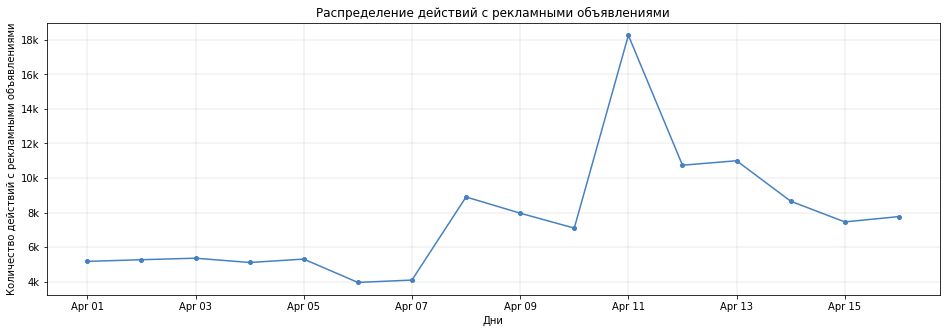

In [2]:
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

csv_reader = pandas.read_csv('test_data.csv',
                             sep = ',',
                             parse_dates = ['date'])

pandas.set_option('display.precision', 10)
fig, ax = plt.subplots(figsize = (16, 5))
data = csv_reader.groupby(['date'])['event'].count()
ax.plot(data,
        linestyle = '-', color = '#4680C2',
        marker = '.', markersize = 8, markerfacecolor = '#4680C2')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, pos: '%.0fk' % (y * 1e-3)))
plt.title('Распределение действий с рекламными объявлениями')
plt.xlabel('Дни')
plt.ylabel('Количество действий с рекламными объявлениями')
plt.grid(color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)

plt.show()

# Анализ
Во-первых, можно проверить данные на дублирование, т.е. **удалить все повторяющиеся записи** (выделить в отдельный DataFrame для последующего анализа).

In [3]:
uniq_csv = csv_reader.drop_duplicates(keep = 'first')
nonuniq_csv = csv_reader[csv_reader.duplicated(keep = 'first')]
print('До:         %.0f' % csv_reader.shape[0])
print('После:      %.0f' % uniq_csv.shape[0])
print('Дубликатов: %.0f, вкл. %.0f от 11 апреля' %\
      (nonuniq_csv.shape[0],
       nonuniq_csv[(nonuniq_csv.date == '2019-04-11')].shape[0]))

До:         122097
После:      120961
Дубликатов: 1136, вкл. 617 от 11 апреля


В данных оказалось **1136 дубликатов**. Очевидно, что их количество будет расти с количеством рекламных действий.<br>
Убедимся в этом, построив график распределения дубликатов по дням.

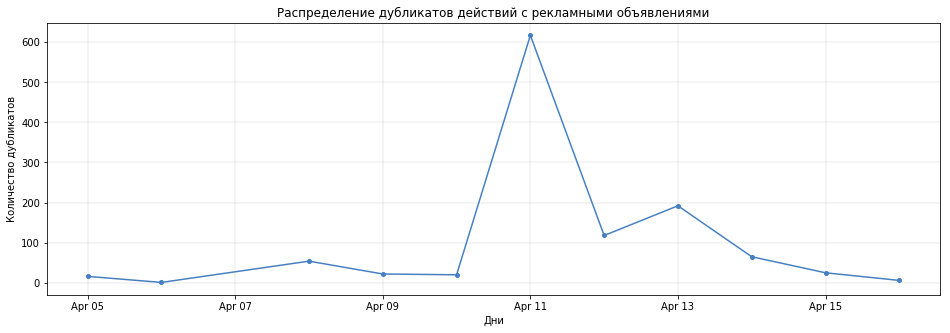

In [4]:
fig, ax = plt.subplots(figsize = (16, 5))
data = nonuniq_csv.groupby(['date'])['event'].count()
ax.plot(data,
        linestyle = '-', color = '#4680C2',
        marker = '.', markersize = 8, markerfacecolor = '#4680C2')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.title('Распределение дубликатов действий с рекламными объявлениями')
plt.xlabel('Дни')
plt.ylabel('Количество дубликатов')
plt.grid(which = 'major',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.grid(which = 'minor',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)

plt.show()

### Далее для анализа будут использоваться только уникальные записи.
Посмотрим, какой именно из типов взаимодействия (показ / клик / жалоба) оказал наибольшее влияние, а также с какой платформы происходили действия.

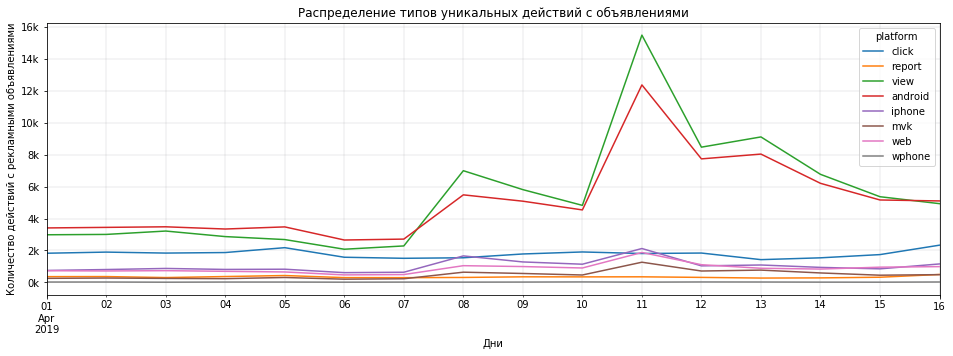

In [5]:
fig, ax = plt.subplots(figsize = (16, 5))
event_data = uniq_csv.pivot_table(index = 'date',
                                  columns = 'event',
                                  aggfunc = 'size')
platform_data = uniq_csv.pivot_table(index = 'date',
                                     columns = 'platform',
                                     aggfunc = 'size')
event_data.plot(ax = ax)
platform_data.plot(ax = ax)

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, pos: '%.0fk' % (y * 1e-3)))
plt.title('Распределение типов уникальных действий с объявлениями')
plt.xlabel('Дни')
plt.ylabel('Количество действий с рекламными объявлениями')
plt.grid(which = 'major',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.grid(which = 'minor',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)

plt.show()

По графику видно, что произошло большое увелечение количества **показов объявлений** (view, зеленая линия) **на платформе Android** (красная линия).<br>
Для более подробного изучения данного всплекса построим сводную таблицу по датам и характеристикам рекламных объявлений (агенство, клиент, кампания и само объявление), а затем отсортируем ее по количеству действий 11 апреля.<br>

In [6]:
data = uniq_csv.pivot_table(
    index = ['agency_union_id',
             'client_union_id',
             'campaign_union_id',
             'ad_id'],
    columns = 'date',
    aggfunc = 'size').sort_values(by = '2019-04-11', ascending = False)
data

date                                                         2019-04-01  \
agency_union_id client_union_id campaign_union_id ad_id                   
agency_2        client_47270    campaign_49554    ad_49554          NaN   
                                                  ad_49556          NaN   
                                                  ad_49560          NaN   
                                                  ad_49564          NaN   
no_agency       client_6        campaign_387      ad_388            NaN   
agency_2        client_47269    campaign_47269    ad_47269          NaN   
agency_29       client_99239    campaign_99242    ad_99303          NaN   
no_agency       client_6        campaign_387      ad_387            NaN   
                client_7        campaign_1181     ad_1181           NaN   
agency_1589     client_116532   campaign_116726   ad_116811         NaN   
no_agency       client_645      campaign_15893    ad_15944          7.0   
agency_491      client_111056   campaign_111076   ad_111076         NaN   
no_agency       client_23       campaign_3021     ad_3021           NaN   
                client_42       campaign_5822     ad_6302          24.0   
                client_979      campaign_17074    ad_17074         28.0   
                client_42       campaign_5822     ad_6304          15.0   
agency_148      client_105218   campaign_105218   ad_105218         NaN   
agency_158      client_106761   campaign_106895   ad_106895         3.0   
agency_33       client_99583    campaign_99643    ad_99643        102.0   
                                campaign_99644    ad_100220        24.0   
no_agency       client_21618    campaign_32728    ad_32728          NaN   
agency_155      client_105617   campaign_106015   ad_106015         NaN   
agency_77       client_103781   campaign_103788   ad_104175         NaN   
no_agency       client_22       campaign_2852     ad_2852           5.0   
                client_42       campaign_5822     ad_6308          24.0   
agency_2170     client_117770   campaign_117900   ad_117901         NaN   
no_agency       client_2111     campaign_20171    ad_20252          NaN   
agency_77       client_103781   campaign_103781   ad_103781        16.0   
no_agency       client_7875     campaign_23980    ad_23980          NaN   
                client_8252     campaign_24261    ad_24266          NaN   
...                                                                 ...   
                client_9813     campaign_25395    ad_25422          1.0   
                                campaign_25396    ad_25423          NaN   
                                campaign_25397    ad_25424          NaN   
                                campaign_25398    ad_25425          NaN   
                                campaign_25402    ad_25426          NaN   
                                campaign_25418    ad_25428          NaN   
                                campaign_25420    ad_25429          NaN   
                client_9817     campaign_25430    ad_25430          NaN   
                                campaign_25431    ad_25433          NaN   
                                campaign_25433    ad_25440          NaN   
                                campaign_25435    ad_25448          NaN   
                                campaign_25439    ad_25451          NaN   
                client_9887     campaign_25452    ad_25452          NaN   
                client_989      campaign_17362    ad_17362          NaN   
                client_990      campaign_17372    ad_17372          1.0   
                client_992      campaign_17375    ad_17375          2.0   
                                                  ad_17376          NaN   
                                                  ad_17379          NaN   
                client_994      campaign_17381    ad_17381          NaN   
                                                  ad_17385          NaN   
                         

Из нее следует, что **клиент 47270** (client_47270) из **агенства 2** (agency_2) запустил **кампанию 49554** (campaign_49554), из которой **объявление 49554** и принесло такой всплеск просмотров 11 апреля (на втором месте объявление 49556).<br>
# Определение выброса
Для определения выброса на любом временном участке будем использовать **медиану M** (потому что среднее сильно зависит от каждого значения => выброс повлияет на него, а этого нам не надо) и **стандартное отклонение σ.**<br>
В качестве предела для определения выброса в ту или иную сторону (резкий спад активности — может, что-то сломалось?) **для всего графика** возьмем пороговое значение равное **±2σ.**

In [7]:
df = uniq_csv.groupby(['date'])['event'].count()

sd = round(df.mean(), 1)
M = round(df.median(), 1)
sigma = round(df.std(), 1)

print('x̅: %s  (среднее по выборке)' % sd)
print('M: %s  (медиана)' % M)
print('σ: %s  (стандартное отклонение)' % sigma)

x̅: 7560.1  (среднее по выборке)
M: 7255.0  (медиана)
σ: 3432.5  (стандартное отклонение)


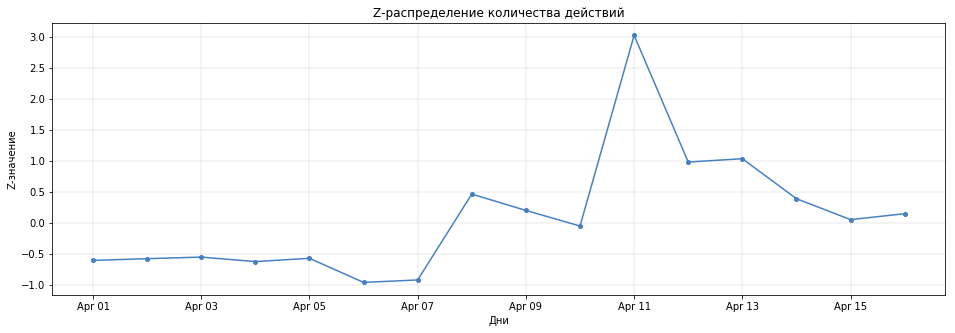

In [8]:
df_zscore = (df - M) / sigma
df_zscore = df_zscore.to_frame()

fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(df_zscore,
        linestyle = '-', color = '#4680C2',
        marker = '.', markersize = 8, markerfacecolor = '#4680C2')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.title('Z-распределение количества действий')
plt.xlabel('Дни')
plt.ylabel('Z-значение')
plt.grid(which = 'major',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.grid(which = 'minor',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)


plt.show()

Выделим данный алгоритм в отдельную функцию и попробуем его на предложенных данных.
В качестве аргументов функции будут использоваться сам график с уникальными данными, модуль порогового Z-значение (по умолчанию |±2|) и период проверки в минутах (по умолчанию последние 60 минут).

In [9]:
from datetime import datetime
def check_df(df, edge = 2, period = 60):
    # реальные данные, берем текущее время
    # end = int(datetime.now().timestamp())
        
    # в нашем случае данные за определенный промежуток,
    # поэтому выберем последнее время из него
    end = int(df['time'].max())
    start = end - period * 60
    df = df[(start <= df.time) & (df.time <= end)]
    
    
    # если анализируемый период больше суток,
    # группируем по дням
    if period > 1440:
        df = df.groupby(by = ['date'])['event'].count()    
    # если больше часа,
    # по часам
    elif 60 < period <= 1440:
        df = df.groupby(by = [
                              df.time.map(lambda i: i % 86400 // 60 // 60)
                             ])['event'].count()
    # иначе по минутам
    else:
        df = df.groupby(by = [
                              df.time.map(lambda i: i % 86400 // 60 % 60)
                             ])['event'].count()

    sd = round(df.mean(), 1)
    M = round(df.median(), 1)
    sigma = round(df.std(), 1)
    
    df_zscore = (df - M) / sigma
    df_zscore = df_zscore.to_frame()
    
    response = []
    if (df_zscore.event >= edge).any():
        response += [df[df_zscore.event >= edge]]
    if (df_zscore.event <= -edge).any():
        response += [df[df_zscore.event <= edge]]
    
    if response != []:
        return {'response': True,
                'df': pandas.concat(response, axis = 1),
                'df_zscore': df_zscore,
                'sd': sd,
                'M': M,
                'sigma': sigma}
    else:
        return {'response': False,
                'df_zscore': df_zscore}
    

Попробуем алгоритм на предложенных данных. Будем анализировать последнюю неделю (начиная с 10 апреля).

Есть выброс
                   event
date                    
2019-04-10 -0.4103384682
2019-04-11  2.4547081796
2019-04-12  0.5508244739
2019-04-13  0.6009980473
2019-04-14  0.0000000000
2019-04-15 -0.3143306574
2019-04-16 -0.2253742677


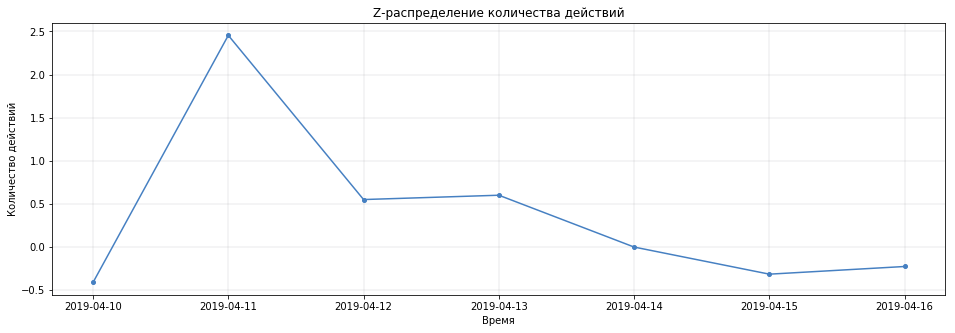

In [10]:
result = check_df(uniq_csv, period = 10080)
if result['response'] is True:
    # пишем аналитику, что у нас выброс
    print('Есть выброс')
    print(result['df_zscore'])
else:
    # все ок, выбросов нет
    print('Выбросов нет')

    
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(result['df_zscore'],
        linestyle = '-', color = '#4680C2',
        marker = '.', markersize = 8, markerfacecolor = '#4680C2')
plt.title('Z-распределение количества действий')
plt.xlabel('Время')
plt.ylabel('Количество действий')
plt.grid(which = 'major',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.grid(which = 'minor',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.show()

Настраиваемый период позволяет анализировать данные как по дням, так и почасам / минутам. Благодаря этому можем проанализировать как прошедшие сутки:

Есть выброс
             event
time              
0.0  -1.2891874600
1.0  -1.9225847729
2.0  -2.0953294946
3.0  -1.9097888676
4.0  -1.7754318618
5.0  -1.4427383237
6.0  -0.9436980166
7.0  -0.1887396033
8.0   0.0927703135
9.0  -0.0415866923
10.0  0.0415866923
11.0  0.5022392834
12.0  0.6110044786
13.0  0.1375559821
14.0 -0.1823416507
15.0 -0.2335252719
16.0  0.5022392834
17.0  0.4574536148
18.0  0.4638515675
19.0  0.6429942418
20.0  1.4363403711
21.0  1.0524632118
22.0  0.0863723608
23.0 -0.2847088932


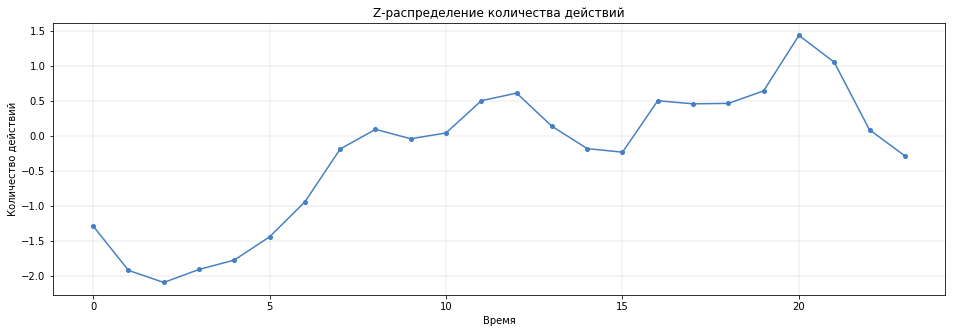

In [11]:
result = check_df(uniq_csv, period = 1440)
if result['response'] is True:
    # пишем аналитику, что у нас выброс
    print('Есть выброс')
    print(result['df_zscore'])
else:
    # все ок, выбросов нет
    print('Выбросов нет')

    
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(result['df_zscore'],
        linestyle = '-', color = '#4680C2',
        marker = '.', markersize = 8, markerfacecolor = '#4680C2')
plt.title('Z-распределение количества действий')
plt.xlabel('Время')
plt.ylabel('Количество действий')
plt.grid(which = 'major',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.grid(which = 'minor',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.show()

Так и прошедший час:

Есть выброс
             event
time              
0.0  -0.8333333333
1.0   0.4166666667
2.0  -0.4166666667
3.0   0.0000000000
4.0   0.8333333333
5.0  -0.8333333333
6.0  -0.8333333333
7.0  -1.2500000000
8.0   0.4166666667
9.0   0.0000000000
10.0  0.0000000000
11.0  0.0000000000
12.0  0.0000000000
13.0 -0.8333333333
14.0 -1.6666666667
15.0 -0.8333333333
16.0 -0.8333333333
17.0 -0.8333333333
18.0  2.0833333333
19.0 -2.0833333333
20.0 -0.8333333333
21.0  0.0000000000
22.0  0.0000000000
23.0 -1.2500000000
24.0 -1.2500000000
25.0 -0.4166666667
26.0 -1.6666666667
27.0  0.0000000000
28.0  0.4166666667
29.0  2.0833333333
30.0 -1.2500000000
31.0  1.2500000000
32.0  0.8333333333
33.0  0.0000000000
34.0 -1.2500000000
35.0  0.0000000000
36.0  0.4166666667
37.0 -0.4166666667
38.0  0.0000000000
39.0 -1.6666666667
40.0 -0.8333333333
41.0  1.2500000000
42.0 -0.8333333333
43.0  0.8333333333
44.0 -1.6666666667
45.0 -1.2500000000
46.0  0.4166666667
47.0  0.4166666667
48.0 -1.6666666667
49.0 -0.8333333333


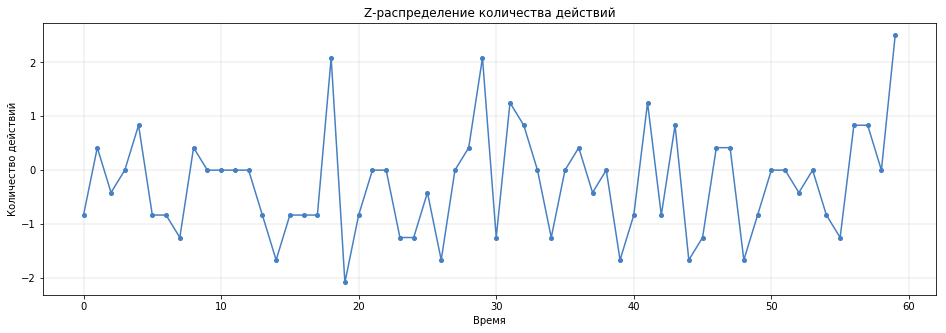

In [12]:
result = check_df(uniq_csv, period = 60)
if result['response'] is True:
    # пишем аналитику, что у нас выброс
    print('Есть выброс')
    print(result['df_zscore'])
else:
    # все ок, выбросов нет
    print('Выбросов нет')

    
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(result['df_zscore'],
        linestyle = '-', color = '#4680C2',
        marker = '.', markersize = 8, markerfacecolor = '#4680C2')
plt.title('Z-распределение количества действий')
plt.xlabel('Время')
plt.ylabel('Количество действий')
plt.grid(which = 'major',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.grid(which = 'minor',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.show()

Так и прошедшие 5 минут:

Выбросов нет


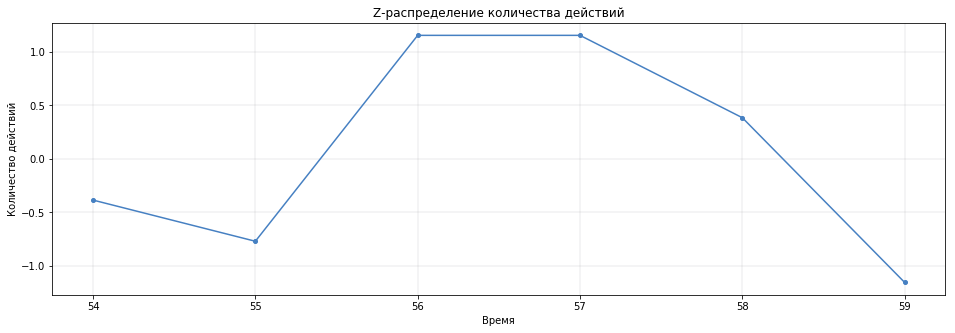

In [13]:
result = check_df(uniq_csv, period = 5)
if result['response'] is True:
    # пишем аналитику, что у нас выброс
    print('Есть выброс')
    print(result['df_zscore'])
else:
    # все ок, выбросов нет
    print('Выбросов нет')

    
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(result['df_zscore'],
        linestyle = '-', color = '#4680C2',
        marker = '.', markersize = 8, markerfacecolor = '#4680C2')
plt.title('Z-распределение количества действий')
plt.xlabel('Время')
plt.ylabel('Количество действий')
plt.grid(which = 'major',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.grid(which = 'minor',
         color = '#32363b',
         linestyle = '-', linewidth = 0.2, alpha = 0.5)
plt.show()

Очевидно, что с уменьшением или увеличением периода анализа необходимо корректировать пороговое значение.
Функция check_df() позволяет изменять его, что делает ее универсальной для анализа почти любого промежутка времени.

# Итоги
Воспроизведя график по полученным данным и проанализировав его, можно сказать, что, несмотря на небольшое количество дубликатов, **выброс 11 апреля произошел из-за объявления 49554 из кампании 49554 от клиента 47270 из агенства 2.**<br>
Также при правильной настройке порогового значения в соответствии с периодом можно применять определение выбросов с помощью Z-значения.